# **Running Python Scripts**

In [8]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [9]:
!pip install tensorflow==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Att

In [3]:
!pip install scikit-learn h5py pyshark protobuf==3.19.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00


In [23]:
!python3 /content/drive/MyDrive/'Lucid DDoS'/lucid_cnn.py --train /content/drive/MyDrive/'Lucid DDoS'/sample-dataset/

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 46ms/step - loss: 0.0486 - accuracy: 0.9888 - val_loss: 0.1101 - val_accuracy: 0.9681
Epoch 336/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0481 - accuracy: 0.9893
Epoch 336: val_accuracy did not improve from 0.98526
2/2 [==============================] - 0s 56ms/step - loss: 0.0487 - accuracy: 0.9885 - val_loss: 0.1099 - val_accuracy: 0.9705
Epoch 337/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9873
Epoch 337: val_accuracy did not improve from 0.98526
2/2 [==============================] - 0s 48ms/step - loss: 0.0504 - accuracy: 0.9888 - val_loss: 0.1098 - val_accuracy: 0.9705
Epoch 338/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0481 - accuracy: 0.9897
Epoch 338: val_accuracy did not improve from 0.98526
2/2 [==============================] - 0s 53ms/step - loss: 0.0471 - accuracy: 0.9888 - val_loss: 0.1098 - val_accurac

# **Playground**

## **UTILITY**

In [1]:
######### UTILITY FILE ############

import numpy as np
import h5py
import glob
from collections import OrderedDict


SEED = 1
MAX_FLOW_LEN = 100 # number of packets
TIME_WINDOW = 10
TRAIN_SIZE = 0.90 # size of the training set wrt the total number of samples

protocols = ['arp','data','dns','ftp','http','icmp','ip','ssdp','ssl','telnet','tcp','udp']
powers_of_two = np.array([2**i for i in range(len(protocols))])


# feature list with min and max values
feature_list = OrderedDict([
    ('timestamp', [0,10]),
    ('packet_length',[0,1<<16]),
    ('highest_layer',[0,1<<32]),
    ('IP_flags',[0,1<<16]),
    ('protocols',[0,1<<len(protocols)]),
    ('TCP_length',[0,1<<16]),
    ('TCP_ack',[0,1<<32]),
    ('TCP_flags',[0,1<<16]),
    ('TCP_window_size',[0,1<<16]),
    ('UDP_length',[0,1<<16]),
    ('ICMP_type',[0,1<<8])]
)

def load_dataset(path):
    filename = glob.glob(path)[0]
    dataset = h5py.File(filename, "r")
    set_x_orig = np.array(dataset["set_x"][:])  # features
    set_y_orig = np.array(dataset["set_y"][:])  # labels

    X_train = np.reshape(set_x_orig, (set_x_orig.shape[0], set_x_orig.shape[1], set_x_orig.shape[2], 1))
    Y_train = set_y_orig#.reshape((1, set_y_orig.shape[0]))

    return X_train, Y_train

def scale_linear_bycolumn(rawpoints, mins,maxs,high=1.0, low=0.0):
    rng = maxs - mins
    return high - (((high - low) * (maxs - rawpoints)) / rng)

def count_packets_in_dataset(X_list):
    packet_counters = []
    for X in X_list:
        TOT = X.sum(axis=2)
        packet_counters.append(np.count_nonzero(TOT))

    return packet_counters

def all_same(items):
    return all(x == items[0] for x in items)

# min/max values of features based on the nominal min/max values of the single features (as defined in the feature_list dict)
def static_min_max(time_window=10):
    feature_list['timestamp'][1] = time_window

    min_array = np.zeros(len(feature_list))
    max_array = np.zeros(len(feature_list))

    i=0
    for feature, value in feature_list.items():
        min_array[i] = value[0]
        max_array[i] = value[1]
        i+=1

    return min_array,max_array

# min/max values of features based on the values in the dataset
def find_min_max(X,time_window=10):
    sample_len = X[0].shape[1]
    max_array = np.zeros((1,sample_len))
    min_array = np.full((1, sample_len),np.inf)

    for feature in X:
        temp_feature = np.vstack([max_array,feature])
        max_array = np.amax(temp_feature,axis=0)
        temp_feature = np.vstack([min_array, feature])
        min_array = np.amin(temp_feature, axis=0)

    # flows cannot last for more than MAX_FLOW_DURATION seconds, so they are normalized accordingly
    max_array[0] = time_window
    min_array[0] = 0

    return min_array,max_array

def normalize_and_padding(X,mins,maxs,max_flow_len,padding=True):
    norm_X = []
    for sample in X:
        if sample.shape[0] > max_flow_len: # if the sample is bigger than expected, we cut the sample
            sample = sample[:max_flow_len,...]
        packet_nr = sample.shape[0] # number of packets in one sample

        norm_sample = scale_linear_bycolumn(sample, mins, maxs, high=1.0, low=0.0)
        np.nan_to_num(norm_sample, copy=False)  # remove NaN from the array
        if padding == True:
            norm_sample = np.pad(norm_sample, ((0, max_flow_len - packet_nr), (0, 0)), 'constant',constant_values=(0, 0))  # padding
        norm_X.append(norm_sample)
    return norm_X

def padding(X,max_flow_len):
    padded_X = []
    for sample in X:
        flow_nr = sample.shape[0]
        padded_sample = np.pad(sample, ((0, max_flow_len - flow_nr), (0, 0)), 'constant',
                              constant_values=(0, 0))  # padding
        padded_X.append(padded_sample)
    return padded_X

## **Parser**

In [5]:
import sys
import time
import pyshark
import socket
import pickle
import random
import hashlib
import argparse
import ipaddress
from sklearn.feature_extraction.text import CountVectorizer
from multiprocessing import Process, Manager, Value, Queue

# Sample commands
# split a pcap file into smaller chunks to leverage multi-core CPUs: tcpdump -r dataset.pcap -w dataset-chunk -C 1000
# dataset parsing (first step): python3 lucid_dataset_parser.py --dataset_type SYN2020 --dataset_folder ./sample-dataset/ --packets_per_flow 10 --dataset_id SYN2020 --traffic_type all --time_window 10
# dataset parsing (second step): python3 lucid_dataset_parser.py --preprocess_folder ./sample-dataset/

IDS2018_DDOS_FLOWS = {'attackers': ['18.218.115.60', '18.219.9.1','18.219.32.43','18.218.55.126','52.14.136.135','18.219.5.43','18.216.200.189','18.218.229.235','18.218.11.51','18.216.24.42'],
                      'victims': ['18.218.83.150','172.31.69.28']}

IDS2017_DDOS_FLOWS = {'attackers': ['172.16.0.1'],
                      'victims': ['192.168.10.50']}

CUSTOM_DDOS_SYN = {'attackers': ['11.0.0.' + str(x) for x in range(1,255)],
                      'victims': ['10.42.0.2']}

DOS2019_FLOWS = {'attackers': ['172.16.0.5'], 'victims': ['192.168.50.1', '192.168.50.4']}

DDOS_ATTACK_SPECS = {
    'DOS2017' : IDS2017_DDOS_FLOWS,
    'DOS2018' : IDS2018_DDOS_FLOWS,
    'SYN2020' : CUSTOM_DDOS_SYN,
    'DOS2019': DOS2019_FLOWS
}


vector_proto = CountVectorizer()
vector_proto.fit_transform(protocols).todense()

random.seed(SEED)
np.random.seed(SEED)

class packet_features:
    def __init__(self):
        self.id_fwd = (0,0,0,0,0) # 5-tuple src_ip_addr, src_port,,dst_ip_addr,dst_port,protocol
        self.id_bwd = (0,0,0,0,0)  # 5-tuple src_ip_addr, src_port,,dst_ip_addr,dst_port,protocol
        self.features_list = []


    def __str__(self):
        return "{} -> {}".format(self.id_fwd, self.features_list)

def get_ddos_flows(attackers,victims):
    DDOS_FLOWS = {}

    if '/' in attackers: # subnet
        DDOS_FLOWS['attackers'] = [str(ip) for ip in list(ipaddress.IPv4Network(attackers).hosts())]
    else: # single address
        DDOS_FLOWS['attackers'] = [str(ipaddress.IPv4Address(attackers))]

    if '/' in victims:  # subnet
        DDOS_FLOWS['victims'] = [str(ip) for ip in list(ipaddress.IPv4Network(victims).hosts())]
    else:  # single address
        DDOS_FLOWS['victims'] = [str(ipaddress.IPv4Address(victims))]

    return DDOS_FLOWS

# function that build the labels based on the dataset type
def parse_labels(dataset_type=None, attackers=None,victims=None, label=1):
    output_dict = {}

    if attackers is not None and victims is not None:
        DDOS_FLOWS = get_ddos_flows(attackers, victims)
    elif dataset_type is not None and dataset_type in DDOS_ATTACK_SPECS:
        DDOS_FLOWS = DDOS_ATTACK_SPECS[dataset_type]
    else:
        return None

    for attacker in DDOS_FLOWS['attackers']:
        for victim in DDOS_FLOWS['victims']:
            ip_src = str(attacker)
            ip_dst = str(victim)
            key_fwd = (ip_src, ip_dst)
            key_bwd = (ip_dst, ip_src)

            if key_fwd not in output_dict:
                output_dict[key_fwd] = label
            if key_bwd not in output_dict:
                output_dict[key_bwd] = label

    return output_dict

def parse_packet(pkt):
    pf = packet_features()
    tmp_id = [0,0,0,0,0]

    try:
        pf.features_list.append(float(pkt.sniff_timestamp))  # timestampchild.find('Tag').text
        pf.features_list.append(int(pkt.ip.len))  # packet length
        pf.features_list.append(int(hashlib.sha256(str(pkt.highest_layer).encode('utf-8')).hexdigest(),
                                    16) % 10 ** 8)  # highest layer in the packet
        pf.features_list.append(int(int(pkt.ip.flags, 16)))  # IP flags
        tmp_id[0] = str(pkt.ip.src)  # int(ipaddress.IPv4Address(pkt.ip.src))
        tmp_id[2] = str(pkt.ip.dst)  # int(ipaddress.IPv4Address(pkt.ip.dst))

        protocols = vector_proto.transform([pkt.frame_info.protocols]).toarray().tolist()[0]
        protocols = [1 if i >= 1 else 0 for i in
                     protocols]  # we do not want the protocols counted more than once (sometimes they are listed twice in pkt.frame_info.protocols)
        protocols_value = int(np.dot(np.array(protocols), powers_of_two))
        pf.features_list.append(protocols_value)

        protocol = int(pkt.ip.proto)
        tmp_id[4] = protocol
        if pkt.transport_layer != None:
            if protocol == socket.IPPROTO_TCP:
                tmp_id[1] = int(pkt.tcp.srcport)
                tmp_id[3] = int(pkt.tcp.dstport)
                pf.features_list.append(int(pkt.tcp.len))  # TCP length
                pf.features_list.append(int(pkt.tcp.ack))  # TCP ack
                pf.features_list.append(int(pkt.tcp.flags, 16))  # TCP flags
                pf.features_list.append(int(pkt.tcp.window_size_value))  # TCP window size
                pf.features_list = pf.features_list + [0, 0]  # UDP + ICMP positions
            elif protocol == socket.IPPROTO_UDP:
                pf.features_list = pf.features_list + [0, 0, 0, 0]  # TCP positions
                tmp_id[1] = int(pkt.udp.srcport)
                pf.features_list.append(int(pkt.udp.length))  # UDP length
                tmp_id[3] = int(pkt.udp.dstport)
                pf.features_list = pf.features_list + [0]  # ICMP position
        elif protocol == socket.IPPROTO_ICMP:
            pf.features_list = pf.features_list + [0, 0, 0, 0, 0]  # TCP and UDP positions
            pf.features_list.append(int(pkt.icmp.type))  # ICMP type
        else:
            pf.features_list = pf.features_list + [0, 0, 0, 0, 0, 0]  # padding for layer3-only packets
            tmp_id[4] = 0

        pf.id_fwd = (tmp_id[0], tmp_id[1], tmp_id[2], tmp_id[3], tmp_id[4])
        pf.id_bwd = (tmp_id[2], tmp_id[3], tmp_id[0], tmp_id[1], tmp_id[4])

        return pf

    except AttributeError as e:
        # ignore packets that aren't TCP/UDP or IPv4
        return None

# Offline preprocessing of pcap files for model training, validation and testing
def process_pcap(pcap_file,dataset_type,in_labels,max_flow_len,labelled_flows,max_flows=0, traffic_type='all',time_window=TIME_WINDOW):
    start_time = time.time()
    temp_dict = OrderedDict()
    start_time_window = -1

    pcap_name = pcap_file.split("/")[-1]
    print("Processing file: ", pcap_name)

    cap = pyshark.FileCapture(pcap_file)
    for i, pkt in enumerate(cap):
        if i % 1000 == 0:
            print(pcap_name + " packet #", i)

        # start_time_window is used to group packets/flows captured in a time-window
        if start_time_window == -1 or float(pkt.sniff_timestamp) > start_time_window + time_window:
            start_time_window = float(pkt.sniff_timestamp)

        pf = parse_packet(pkt)
        store_packet(pf, temp_dict, start_time_window, max_flow_len)
        if max_flows > 0 and len(temp_dict) >= max_flows:
            break

    apply_labels(temp_dict, labelled_flows, in_labels, traffic_type)
    print('Completed file {} in {} seconds.'.format(pcap_name, time.time() - start_time))

# Transforms live traffic into input samples for inference
def process_live_traffic(cap, dataset_type, in_labels, max_flow_len, traffic_type='all',time_window=TIME_WINDOW):
    start_time = time.time()
    temp_dict = OrderedDict()
    labelled_flows = []

    start_time_window = start_time
    time_window = start_time_window + time_window

    if isinstance(cap, pyshark.LiveCapture) == True:
        for pkt in cap.sniff_continuously():
            if time.time() >= time_window:
                break
            pf = parse_packet(pkt)
            temp_dict = store_packet(pf, temp_dict, start_time_window, max_flow_len)
    elif isinstance(cap, pyshark.FileCapture) == True:
        while time.time() < time_window:
            try:
                pkt = cap.next()
                pf = parse_packet(pkt)
                temp_dict = store_packet(pf,temp_dict,start_time_window,max_flow_len)
            except:
                break

    apply_labels(temp_dict,labelled_flows, in_labels,traffic_type)
    return labelled_flows

def store_packet(pf,temp_dict,start_time_window, max_flow_len):
    if pf is not None:
        if pf.id_fwd in temp_dict and start_time_window in temp_dict[pf.id_fwd] and \
                temp_dict[pf.id_fwd][start_time_window].shape[0] < max_flow_len:
            temp_dict[pf.id_fwd][start_time_window] = np.vstack(
                [temp_dict[pf.id_fwd][start_time_window], pf.features_list])
        elif pf.id_bwd in temp_dict and start_time_window in temp_dict[pf.id_bwd] and \
                temp_dict[pf.id_bwd][start_time_window].shape[0] < max_flow_len:
            temp_dict[pf.id_bwd][start_time_window] = np.vstack(
                [temp_dict[pf.id_bwd][start_time_window], pf.features_list])
        else:
            if pf.id_fwd not in temp_dict and pf.id_bwd not in temp_dict:
                temp_dict[pf.id_fwd] = {start_time_window: np.array([pf.features_list]), 'label': 0}
            elif pf.id_fwd in temp_dict and start_time_window not in temp_dict[pf.id_fwd]:
                temp_dict[pf.id_fwd][start_time_window] = np.array([pf.features_list])
            elif pf.id_bwd in temp_dict and start_time_window not in temp_dict[pf.id_bwd]:
                temp_dict[pf.id_bwd][start_time_window] = np.array([pf.features_list])
    return temp_dict

def apply_labels(flows, labelled_flows, labels, traffic_type):
    for five_tuple, flow in flows.items():
        if labels is not None:
            short_key = (five_tuple[0], five_tuple[2])  # for IDS2017/IDS2018 dataset the labels have shorter keys
            flow['label'] = labels.get(short_key, 0)

        for flow_key, packet_list in flow.items():
            # relative time wrt the time of the first packet in the flow
            if flow_key != 'label':
                amin = np.amin(packet_list,axis=0)[0]
                packet_list[:, 0] = packet_list[:, 0] - amin

        if traffic_type == 'ddos' and flow['label'] == 0: # we only want malicious flows from this dataset
            continue
        elif traffic_type == 'benign' and flow['label'] > 0: # we only want benign flows from this dataset
            continue
        else:
            labelled_flows.append((five_tuple,flow))

# returns the total number of flows
def count_flows(preprocessed_flows):
    ddos_flows = 0
    total_flows = len(preprocessed_flows)
    ddos_fragments = 0
    total_fragments = 0
    for flow in preprocessed_flows:
        flow_fragments = len(flow[1]) - 1
        total_fragments += flow_fragments
        if flow[1]['label'] > 0:
            ddos_flows += 1
            ddos_fragments += flow_fragments  # the label does not count

    return (total_flows, ddos_flows, total_flows - ddos_flows), (total_fragments, ddos_fragments, total_fragments-ddos_fragments)

# balance the dataset based on the number of benign and malicious fragments of flows
def balance_dataset(flows,total_fragments=float('inf')):
    new_flow_list = []

    _,(_, ddos_fragments, benign_fragments) = count_flows(flows)

    if ddos_fragments == 0 or benign_fragments == 0:
        min_fragments = total_fragments
    else:
        min_fragments = min(total_fragments/2,ddos_fragments,benign_fragments)

    random.shuffle(flows)
    new_benign_fragments = 0
    new_ddos_fragments = 0

    for flow in flows:
        if flow[1]['label'] == 0 and (new_benign_fragments < min_fragments ):
            new_benign_fragments += len(flow[1]) - 1
            new_flow_list.append(flow)
        elif flow[1]['label'] > 0 and (new_ddos_fragments < min_fragments):
            new_ddos_fragments += len(flow[1]) - 1
            new_flow_list.append(flow)

    return new_flow_list, new_benign_fragments, new_ddos_fragments

# convert the dataset from dictionaries with 5-tuples keys into a list of flow fragments and another list of labels
def dataset_to_list_of_fragments(dataset):
    keys = []
    X = []
    y = []

    for flow in dataset:
        tuple = flow[0]
        flow_data = flow[1]
        label = flow_data['label']
        for key, fragment in flow_data.items():
            if key != 'label':
                X.append(fragment)
                y.append(label)
                keys.append(tuple)

    return X,y,keys

def train_test_split(flow_list,train_size=TRAIN_SIZE, shuffle=True):
    test_list = []
    _,(total_examples,_,_) = count_flows(flow_list)
    test_examples = total_examples - total_examples*train_size

    if shuffle == True:
        random.shuffle(flow_list)

    current_test_examples = 0
    while current_test_examples < test_examples:
        flow = flow_list.pop(0)
        test_list.append(flow)
        current_test_examples += len(flow[1])-1


    return flow_list,test_list

def main(argv):
    command_options = " ".join(str(x) for x in argv[1:])

    help_string = 'Usage[0]: python3 lucid_dataset_parser.py --dataset_type <dataset_name> --dataset_folder <folder path> --dataset_id <dataset identifier> --packets_per_flow <n> --time_window <t>\n' \
                  'Usage[1]: python3 lucid_dataset_parser.py --preprocess_folder <folder path>'
    manager = Manager()

    parser = argparse.ArgumentParser(
        description='Dataset parser',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument('-d', '--dataset_folder', nargs='+', type=str,
                        help='Folder with the dataset')
    parser.add_argument('-o', '--output_folder', nargs='+', type=str,
                        help='Output folder')
    parser.add_argument('-f', '--traffic_type', default='all', nargs='+', type=str,
                        help='Type of flow to process (all, benign, ddos)')
    parser.add_argument('-p', '--preprocess_folder', nargs='+', type=str,
                        help='Folder with preprocessed data')
    parser.add_argument('--preprocess_file', nargs='+', type=str,
                        help='File with preprocessed data')
    parser.add_argument('-b', '--balance_folder', nargs='+', type=str,
                        help='Folder where balancing datasets')
    parser.add_argument('-n', '--packets_per_flow', nargs='+', type=str,
                        help='Packet per flow sample')
    parser.add_argument('-s', '--samples', default=float('inf'), type=int,
                        help='Number of training samples in the reduced output')
    parser.add_argument('-i', '--dataset_id', nargs='+', type=str,
                        help='String to append to the names of output files')
    parser.add_argument('-m', '--max_flows', default=0, type=int,
                        help='Max number of flows to extract from the pcap files')
    parser.add_argument('-l', '--label', default=1, type=int,
                        help='Label assigned to the DDoS class')

    parser.add_argument('-t', '--dataset_type', nargs='+', type=str,
                        help='Type of the dataset. Available options are: DOS2017, DOS2018, DOS2019, SYN2020')

    parser.add_argument('-w', '--time_window', nargs='+', type=str,
                        help='Length of the time window')

    parser.add_argument('--no_split', help='Do not split the dataset', action='store_true')

    args = parser.parse_args()

    if args.packets_per_flow is not None:
        max_flow_len = int(args.packets_per_flow[0])
    else:
        max_flow_len = MAX_FLOW_LEN

    if args.time_window is not None:
        time_window = float(args.time_window[0])
    else:
        time_window = TIME_WINDOW

    if args.dataset_id is not None:
        dataset_id = str(args.dataset_id[0])
    else:
        dataset_id = ''

    if args.traffic_type is not None:
        traffic_type = str(args.traffic_type[0])
    else:
        traffic_type = 'all'

    if args.dataset_folder is not None and args.dataset_type is not None:
        process_list = []
        flows_list = []

        if args.output_folder is not None and os.path.isdir(args.output_folder[0]) is True:
            output_folder = args.output_folder[0]
        else:
            output_folder = args.dataset_folder[0]

        filelist = glob.glob(args.dataset_folder[0]+ '/*.pcap')
        in_labels = parse_labels(args.dataset_type[0],args.dataset_folder[0],label=args.label)

        start_time = time.time()
        for file in filelist:
            try:
                flows = manager.list()
                p = Process(target=process_pcap,args=(file,args.dataset_type[0],in_labels,max_flow_len,flows,args.max_flows, traffic_type,time_window))
                process_list.append(p)
                flows_list.append(flows)
            except FileNotFoundError as e:
                continue

        for p in process_list:
            p.start()

        for p in process_list:
            p.join()

        np.seterr(divide='ignore', invalid='ignore')
        try:
            preprocessed_flows = list(flows_list[0])
        except:
            print ("ERROR: No traffic flows. \nPlease check that the dataset folder name (" + args.dataset_folder[0] + ") is correct and \nthe folder contains the traffic traces in pcap format (the pcap extension is mandatory)")
            exit(1)

        #concatenation of the features
        for results in flows_list[1:]:
            preprocessed_flows = preprocessed_flows + list(results)

        process_time = time.time()-start_time

        if dataset_id == '':
            dataset_id = str(args.dataset_type[0])

        filename = str(int(time_window)) + 't-' + str(max_flow_len) + 'n-' + dataset_id + '-preprocess'
        output_file = output_folder + '/' + filename
        output_file = output_file.replace("//", "/") # remove double slashes when needed

        with open(output_file + '.data', 'wb') as filehandle:
            # store the data as binary data stream
            pickle.dump(preprocessed_flows, filehandle)


        (total_flows, ddos_flows, benign_flows),  (total_fragments, ddos_fragments, benign_fragments) = count_flows(preprocessed_flows)

        log_string = time.strftime("%Y-%m-%d %H:%M:%S") + " | dataset_type:" + args.dataset_type[0] + \
                     " | flows (tot,ben,ddos):(" + str(total_flows) + "," + str(benign_flows) + "," + str(ddos_flows) + \
                     ") | fragments (tot,ben,ddos):(" + str(total_fragments) + "," + str(benign_fragments) + "," + str(ddos_fragments) + \
                     ") | options:" + command_options + " | process_time:" + str(process_time) + " |\n"
        print (log_string)

        # saving log file
        with open(output_folder + '/history.log', "a") as myfile:
            myfile.write(log_string)

    if args.preprocess_folder is not None or args.preprocess_file is not None:
        if args.preprocess_folder is not None:
            output_folder = args.output_folder[0] if args.output_folder is not None else args.preprocess_folder[0]
            filelist = glob.glob(args.preprocess_folder[0] + '/*.data')
        else:
            output_folder = args.output_folder[0] if args.output_folder is not None else os.path.dirname(os.path.realpath(args.preprocess_file[0]))
            filelist = args.preprocess_file

        # obtain time_window and flow_len from filename and ensure that all files have the same values
        time_window = None
        max_flow_len = None
        dataset_id = None
        for file in filelist:
            filename = file.split('/')[-1].strip()
            current_time_window = int(filename.split('-')[0].strip().replace('t',''))
            current_max_flow_len = int(filename.split('-')[1].strip().replace('n',''))
            current_dataset_id = str(filename.split('-')[2].strip())
            if time_window != None and current_time_window != time_window:
                print ("Incosistent time windows!!")
                exit()
            else:
                time_window = current_time_window
            if max_flow_len != None and current_max_flow_len != max_flow_len:
                print ("Incosistent flow lengths!!")
                exit()
            else:
                max_flow_len = current_max_flow_len

            if dataset_id != None and current_dataset_id != dataset_id:
                dataset_id = "IDS201X"
            else:
                dataset_id = current_dataset_id



        preprocessed_flows = []
        for file in filelist:
            with open(file, 'rb') as filehandle:
                # read the data as binary data stream
                preprocessed_flows = preprocessed_flows + pickle.load(filehandle)


        # balance samples and redux the number of samples when requested
        preprocessed_flows, benign_fragments, ddos_fragments = balance_dataset(preprocessed_flows,args.samples)

        if len(preprocessed_flows) == 0:
            print("Empty dataset!")
            exit()

        preprocessed_train, preprocessed_test = train_test_split(preprocessed_flows,train_size=TRAIN_SIZE, shuffle=True)
        preprocessed_train, preprocessed_val = train_test_split(preprocessed_train, train_size=TRAIN_SIZE, shuffle=True)

        X_train, y_train, _ = dataset_to_list_of_fragments(preprocessed_train)
        X_val, y_val, _ = dataset_to_list_of_fragments(preprocessed_val)
        X_test, y_test, _ = dataset_to_list_of_fragments(preprocessed_test)

        # normalization and padding
        X_full = X_train + X_val + X_test
        y_full = y_train + y_val + y_test
        mins,maxs = static_min_max(time_window=time_window)

        total_examples = len(y_full)
        total_ddos_examples = np.count_nonzero(y_full)
        total_benign_examples = total_examples - total_ddos_examples

        output_file = output_folder + '/' + str(time_window) + 't-' + str(max_flow_len) + 'n-' + dataset_id + '-dataset'
        if args.no_split == True: # don't split the dataset
            norm_X_full = normalize_and_padding(X_full, mins, maxs, max_flow_len)
            #norm_X_full = padding(X_full,max_flow_len) # only padding
            norm_X_full_np = np.array(norm_X_full)
            y_full_np = np.array(y_full)

            hf = h5py.File(output_file + '-full.hdf5', 'w')
            hf.create_dataset('set_x', data=norm_X_full_np)
            hf.create_dataset('set_y', data=y_full_np)
            hf.close()

            [full_packets] = count_packets_in_dataset([norm_X_full_np])
            log_string = time.strftime("%Y-%m-%d %H:%M:%S") + " | Total examples (tot,ben,ddos):(" + str(total_examples) + "," + str(total_benign_examples) + "," + str(total_ddos_examples) + \
                         ") | Total packets:(" + str(full_packets) + \
                         ") | options:" + command_options + " |\n"
        else:
            norm_X_train = normalize_and_padding(X_train,mins,maxs,max_flow_len)
            norm_X_val = normalize_and_padding(X_val, mins, maxs, max_flow_len)
            norm_X_test = normalize_and_padding(X_test, mins, maxs, max_flow_len)

            norm_X_train_np = np.array(norm_X_train)
            y_train_np = np.array(y_train)
            norm_X_val_np = np.array(norm_X_val)
            y_val_np = np.array(y_val)
            norm_X_test_np = np.array(norm_X_test)
            y_test_np = np.array(y_test)

            hf = h5py.File(output_file + '-train.hdf5', 'w')
            hf.create_dataset('set_x', data=norm_X_train_np)
            hf.create_dataset('set_y', data=y_train_np)
            hf.close()

            hf = h5py.File(output_file + '-val.hdf5', 'w')
            hf.create_dataset('set_x', data=norm_X_val_np)
            hf.create_dataset('set_y', data=y_val_np)
            hf.close()

            hf = h5py.File(output_file + '-test.hdf5', 'w')
            hf.create_dataset('set_x', data=norm_X_test_np)
            hf.create_dataset('set_y', data=y_test_np)
            hf.close()

            [train_packets, val_packets, test_packets] = count_packets_in_dataset([norm_X_train_np, norm_X_val_np, norm_X_test_np])
            log_string = time.strftime("%Y-%m-%d %H:%M:%S") + " | examples (tot,ben,ddos):(" + str(total_examples) + "," + str(total_benign_examples) + "," + str(total_ddos_examples) + \
                         ") | Train/Val/Test sizes: (" + str(norm_X_train_np.shape[0]) + "," + str(norm_X_val_np.shape[0]) + "," + str(norm_X_test_np.shape[0]) + \
                         ") | Packets (train,val,test):(" + str(train_packets) + "," + str(val_packets) + "," + str(test_packets) + \
                         ") | options:" + command_options + " |\n"

        print(log_string)

        # saving log file
        with open(output_folder + '/history.log', "a") as myfile:
            myfile.write(log_string)

    if args.balance_folder is not None and args.output_folder is not None:
        output_folder = args.output_folder[0] if args.output_folder is not None else args.balance_folder[0]
        datasets = []
        for folder in args.balance_folder:
            datasets += glob.glob(folder + '/*.hdf5')
        train_filelist = {}
        val_filelist = {}
        test_filelist = {}
        min_samples_train = float('inf')
        min_samples_val = float('inf')
        min_samples_test = float('inf')

        output_filename_prefix = None

        for file in datasets:
            filename = file.split('/')[-1].strip()
            dataset = h5py.File(file, "r")
            X = np.array(dataset["set_x"][:])  # features
            Y = np.array(dataset["set_y"][:])  # labels
            if 'train' in filename:
                key = filename.split('dataset')[0].strip() + 'dataset-balanced-train.hdf5'
                if output_filename_prefix ==None:
                    output_filename_prefix = filename.split('IDS')[0].strip()
                else:
                    if filename.split('IDS')[0].strip() != output_filename_prefix:
                        print ("Inconsistent datasets!")
                        exit()
                train_filelist[key] = (X,Y)
                if X.shape[0] < min_samples_train:
                    min_samples_train = X.shape[0]
            elif 'val' in filename:
                key = filename.split('dataset')[0].strip() + 'dataset-balanced-val.hdf5'
                if output_filename_prefix ==None:
                    output_filename_prefix = filename.split('IDS')[0].strip()
                else:
                    if filename.split('IDS')[0].strip() != output_filename_prefix:
                        print ("Inconsistent datasets!")
                        exit()
                val_filelist[key] = (X,Y)
                if X.shape[0] < min_samples_val:
                    min_samples_val = X.shape[0]
            elif 'test' in filename:
                key = filename.split('dataset')[0].strip() + 'dataset-balanced-test.hdf5'
                if output_filename_prefix ==None:
                    output_filename_prefix = filename.split('IDS')[0].strip()
                else:
                    if filename.split('IDS')[0].strip() != output_filename_prefix:
                        print ("Inconsistent datasets!")
                        exit()
                test_filelist[key] = (X, Y)
                if X.shape[0] < min_samples_test:
                    min_samples_test = X.shape[0]

        final_X = {'train':None,'val':None,'test':None}
        final_y = {'train':None,'val':None,'test':None}

        for key,value in train_filelist.items():
            X_short = value[0][:min_samples_train,...]
            y_short = value[1][:min_samples_train,...]

            if final_X['train'] is None:
                final_X['train'] = X_short
                final_y['train'] = y_short
            else:
                final_X['train'] = np.vstack((final_X['train'],X_short))
                final_y['train'] = np.hstack((final_y['train'],y_short))

        for key,value in val_filelist.items():
            X_short = value[0][:min_samples_val,...]
            y_short = value[1][:min_samples_val,...]

            if final_X['val'] is None:
                final_X['val'] = X_short
                final_y['val'] = y_short
            else:
                final_X['val'] = np.vstack((final_X['val'],X_short))
                final_y['val'] = np.hstack((final_y['val'],y_short))


        for key,value in test_filelist.items():
            X_short = value[0][:min_samples_test,...]
            y_short = value[1][:min_samples_test,...]

            if final_X['test'] is None:
                final_X['test'] = X_short
                final_y['test'] = y_short
            else:
                final_X['test'] = np.vstack((final_X['test'],X_short))
                final_y['test'] = np.hstack((final_y['test'],y_short))

        for key,value in final_X.items():
            filename = output_filename_prefix + 'IDS201X-dataset-balanced-' + key + '.hdf5'
            hf = h5py.File(output_folder + '/' + filename, 'w')
            hf.create_dataset('set_x', data=value)
            hf.create_dataset('set_y', data=final_y[key])
            hf.close()

        total_flows = final_y['train'].shape[0]+final_y['val'].shape[0]+final_y['test'].shape[0]
        ddos_flows = np.count_nonzero(final_y['train'])+np.count_nonzero(final_y['val'])+np.count_nonzero(final_y['test'])
        benign_flows = total_flows-ddos_flows
        [train_packets, val_packets, test_packets] = count_packets_in_dataset([final_X['train'], final_X['val'], final_X['test']])
        log_string = time.strftime("%Y-%m-%d %H:%M:%S") + " | total_flows (tot,ben,ddos):(" + str(total_flows) + "," + str(benign_flows) + "," + str(ddos_flows) + \
                     ") | Packets (train,val,test):(" + str(train_packets) + "," + str(val_packets) + "," + str(test_packets) + \
                     ") | Train/Val/Test sizes: (" + str(final_y['train'].shape[0]) + "," + str(final_y['val'].shape[0]) + "," + str(final_y['test'].shape[0]) + \
                     ") | options:" + command_options + " |\n"

        print(log_string)

        # saving log file
        with open(output_folder + '/history.log', "a") as myfile:
            myfile.write(log_string)


    if args.dataset_folder is None and args.preprocess_folder is None and args.preprocess_file is None and args.balance_folder is None:
        print (help_string)
    if args.dataset_type is None and args.dataset_folder is not None:
        print("Please specify the dataset type (DOS2017, DOS2018, DOS2020)!")
        print(help_string)
    if args.output_folder is None and args.balance_folder is not None:
        print("Please specify the output folder!")
        print(help_string)

if __name__ == "__main__":
    main(sys.argv)


Usage[0]: python3 lucid_dataset_parser.py --dataset_type <dataset_name> --dataset_folder <folder path> --dataset_id <dataset identifier> --packets_per_flow <n> --time_window <t>
Usage[1]: python3 lucid_dataset_parser.py --preprocess_folder <folder path>


## **CNN Script**

In [15]:
import tensorflow as tf
import numpy as np
import random as rn
import os
import csv
import pprint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D
from tensorflow.keras.layers import Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
# SEED
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=1)

In [8]:
import tensorflow.keras.backend as K
tf.random.set_seed(SEED)
K.set_image_data_format('channels_last')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config.gpu_options.allow_growth = True

In [9]:
OUTPUT_FOLDER = "./output/"

VAL_HEADER = ['Model', 'Samples', 'Accuracy', 'F1Score', 'Hyper-parameters','Validation Set']
PREDICT_HEADER = ['Model', 'Time', 'Packets', 'Samples', 'DDOS%', 'Accuracy', 'F1Score', 'TPR', 'FPR','TNR', 'FNR', 'Source']

# hyperparameters
PATIENCE = 10
DEFAULT_EPOCHS = 1000
hyperparamters = {
    "learning_rate": [0.1,0.01],
    "batch_size": [1024,2048],
    "kernels": [32,64],
    "regularization" : [None,'l1'],
    "dropout" : [None,0.2]
}

In [10]:
def Conv2DModel(model_name,input_shape,kernel_col, kernels=64,kernel_rows=3,learning_rate=0.01,regularization=None,dropout=None):
    K.clear_session()

    model = Sequential(name=model_name)
    regularizer = regularization

    model.add(Conv2D(kernels, (kernel_rows,kernel_col), strides=(1, 1), input_shape=input_shape, kernel_regularizer=regularizer, name='conv0'))
    if dropout != None and type(dropout) == float:
        model.add(Dropout(dropout))
    model.add(Activation('relu'))

    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', name='fc1'))

    print(model.summary())
    compileModel(model, learning_rate)
    return model

def compileModel(model,lr):
    # optimizer = SGD(learning_rate=lr, momentum=0.0, decay=0.0, nesterov=False)
    optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])  # here we specify the loss function

def plot_training_history(grid_search, model_name, output_folder, time_window, max_flow_len):
    """
    Plot and save training/validation accuracy and loss curves from GridSearchCV results.

    Args:
        grid_search: Fitted GridSearchCV object
        model_name: Name of the model
        output_folder: Directory to save plots
        time_window: Time window parameter
        max_flow_len: Maximum flow length parameter
    """
    # Get the best model's history
    best_model = grid_search.best_estimator_.model

    # Access the history from the model's history attribute
    try:
        history = best_model.history.history
    except AttributeError:
        print("Warning: Could not access history directly. Trying alternative method...")
        try:
            history = grid_search.cv_results_
            print("Available metrics:", history.keys())
            return
        except:
            print("Error: Could not access training history")
            return

    if history is None or len(history) == 0:
        print("Error: No training history found")
        return

    # Create figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation metrics if available
    metrics = {}
    for key in history.keys():
        if 'loss' in key:
            metrics.setdefault('loss', []).append(key)
        if 'acc' in key:
            metrics.setdefault('acc', []).append(key)

    epochs = range(1, len(next(iter(history.values()))) + 1)

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for metric in metrics.get('acc', []):
        if 'val' in metric:
            plt.plot(epochs, history[metric], 'r-', label='Validation Accuracy')
        else:
            plt.plot(epochs, history[metric], 'b-', label='Training Accuracy')
    plt.title(f'{model_name}\nAccuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    for metric in metrics.get('loss', []):
        if 'val' in metric:
            plt.plot(epochs, history[metric], 'r-', label='Validation Loss')
        else:
            plt.plot(epochs, history[metric], 'b-', label='Training Loss')
    plt.title(f'{model_name}\nLoss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Adjust layout and save
    plt.tight_layout()
    plot_filename = f"{output_folder}{time_window}t-{max_flow_len}n-{model_name}-training_history.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.close()


In [11]:
dataset_folder = "/content/drive/MyDrive/'Lucid DDoS'/sample-dataset"

In [13]:
X_train, Y_train = load_dataset("/content/drive/MyDrive/Lucid DDoS/sample-dataset/10t-10n-DOS2019-dataset-train.hdf5")
X_val, Y_val = load_dataset("/content/drive/MyDrive/Lucid DDoS/sample-dataset/10t-10n-DOS2019-dataset-val.hdf5")

In [16]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=SEED)
X_val, Y_val = shuffle(X_val, Y_val, random_state=SEED)

In [17]:
X_train[0]

array([[[0.00000000e+00],
        [1.14440918e-03],
        [1.48505177e-02],
        [0.00000000e+00],
        [5.16601562e-01],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [8.39233398e-04],
        [0.00000000e+00]],

       [[1.90734863e-07],
        [1.14440918e-03],
        [1.48505177e-02],
        [0.00000000e+00],
        [5.16601562e-01],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [8.39233398e-04],
        [0.00000000e+00]],

       [[2.10940838e-03],
        [2.12097168e-03],
        [1.48505177e-02],
        [3.05175781e-05],
        [5.16601562e-01],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.81579590e-03],
        [0.00000000e+00]],

       [[2.10950375e-03],
        [2.12097168e-03],
        [1.48505177e-02],
        [3.05175781e-05],
        [5.16601562e-01],
      

In [28]:
def visualize_matrix(matrix, title="Raw Matrix Visualization"):
    """
    Visualize a single matrix as a heatmap or grayscale image.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', aspect='auto')  # Use 'viridis' or 'gray' for grayscale
    plt.colorbar(label="Value Intensity")
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Time Step (or Sample Index)")
    plt.show()

def visualize_matrices(matrices, num_samples=10):
    """
    Visualize multiple matrices. Display the first `num_samples` matrices.
    """
    for i in range(min(num_samples, len(matrices))):
        visualize_matrix(matrices[i], title=f"Sample {i+1} Matrix")

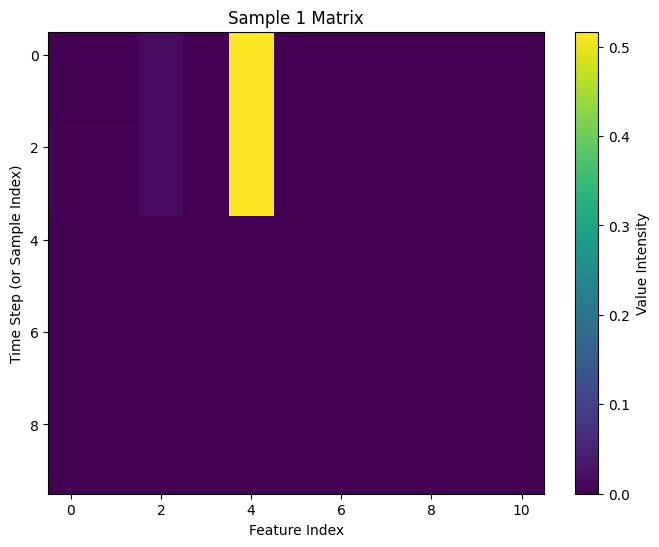

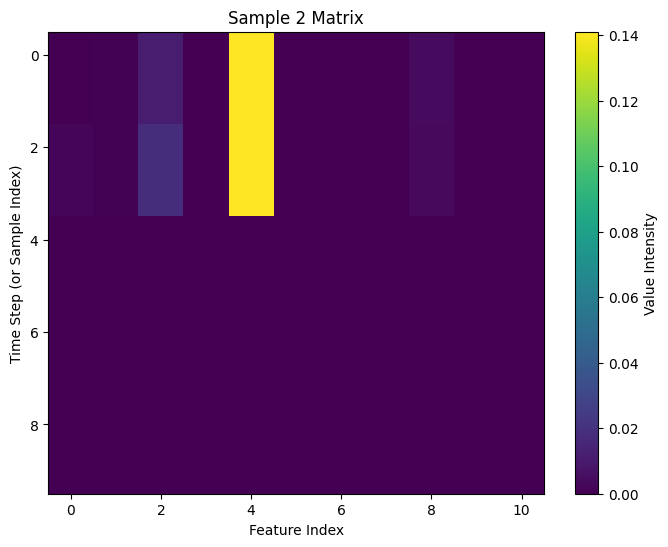

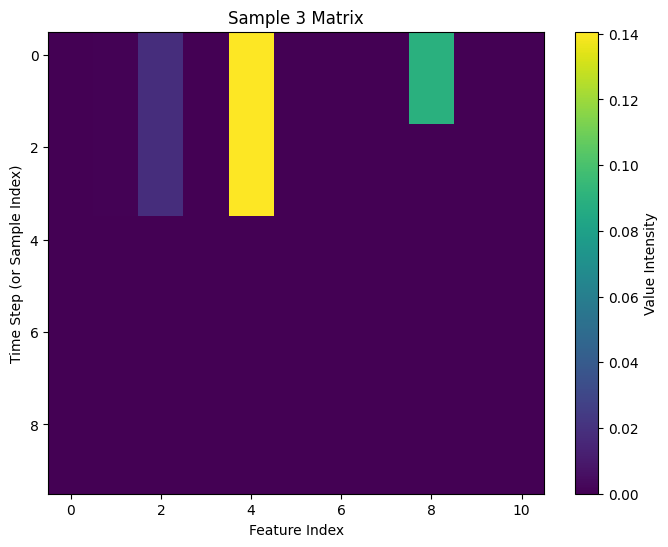

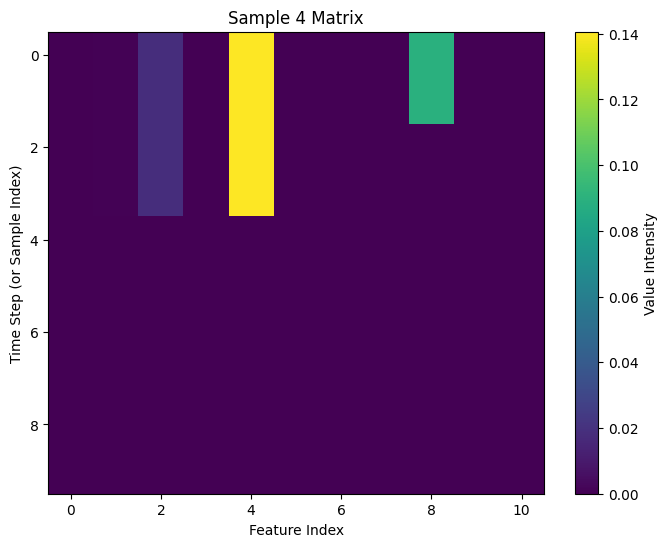

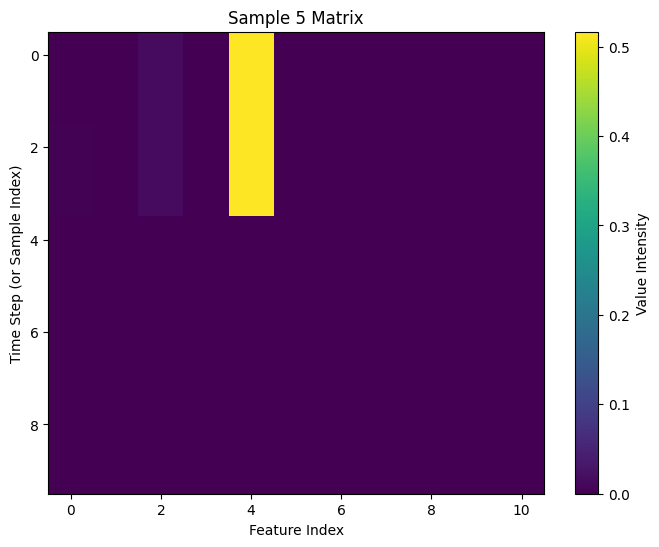

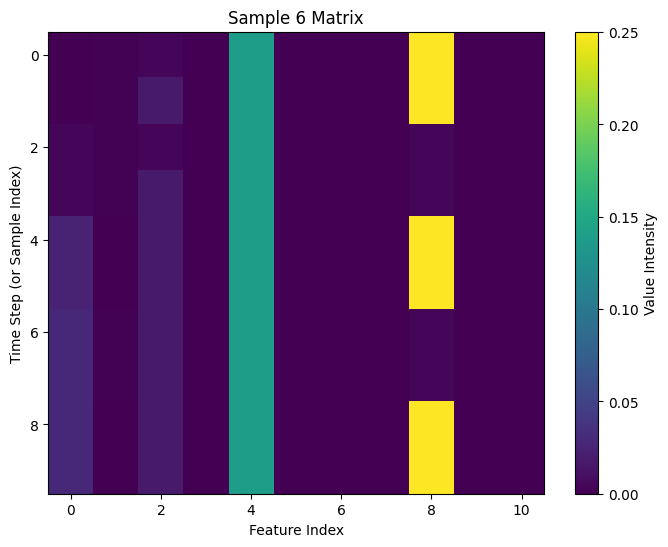

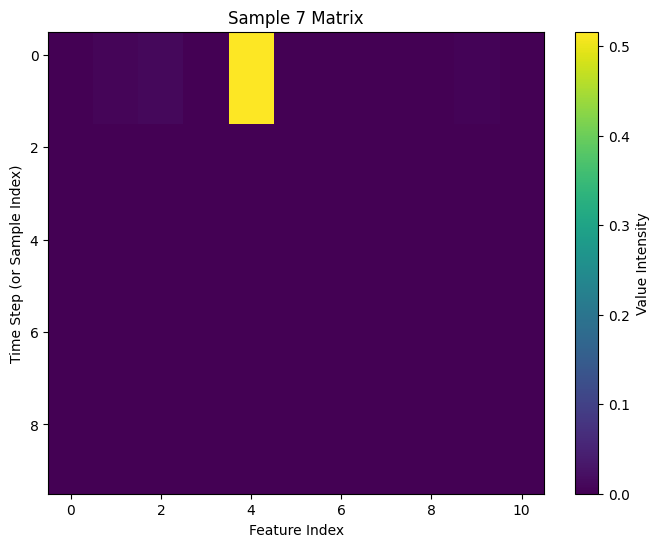

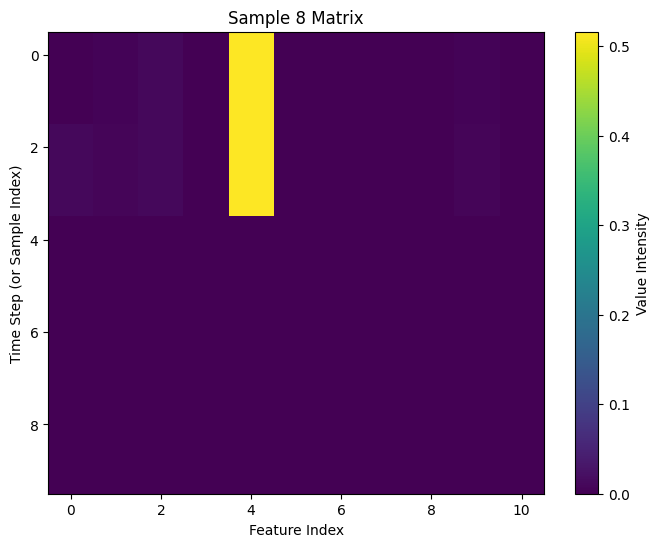

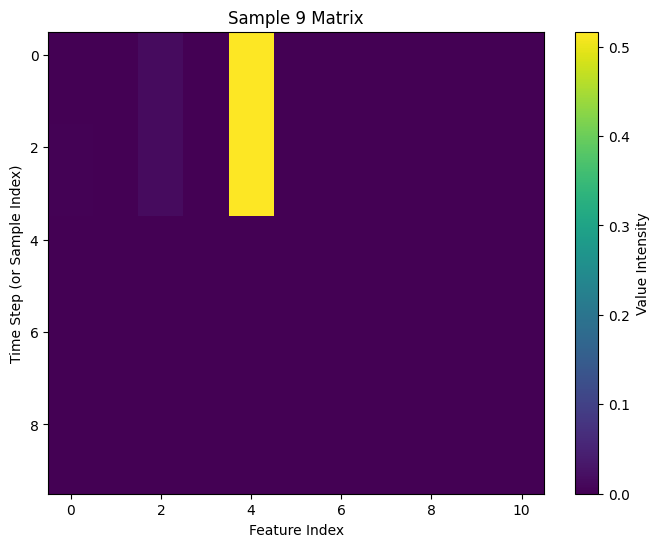

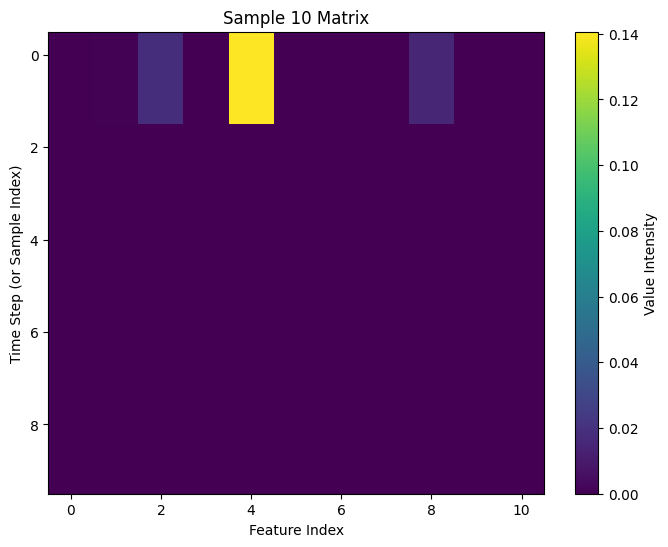

In [29]:
visualize_matrices(X_train)

In [21]:
from tensorflow.keras.models import Model

# Grad-CAM Function
def compute_grad_cam(model, input_data, class_index):
    """
    Compute Grad-CAM for a specific class index.
    Args:
    - model: Trained CNN model.
    - input_data: Preprocessed input sample (single sample).
    - class_index: Index of the class for which Grad-CAM is calculated.
    Returns:
    - heatmap: Grad-CAM heatmap.
    """
    # Get the last convolutional layer
    last_conv_layer = model.get_layer('conv0')

    # Create a model that outputs the feature maps and predictions
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Record operations for gradient computation
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(input_data)
        loss = predictions[:, class_index]

    # Compute gradients of the class score w.r.t. feature maps
    grads = tape.gradient(loss, conv_output)

    # Compute weights by global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute weighted combination of feature maps
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Apply ReLU to retain positive values only
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap to [0, 1]
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()[0]


In [22]:
# Grad-CAM Visualization Function
def visualize_grad_cam(heatmap, input_data, title="Grad-CAM"):
    """
    Visualize Grad-CAM heatmap over the input sample.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(input_data[0, :, :, 0], cmap='gray', aspect='auto', alpha=0.6)  # Overlay input data
    plt.imshow(heatmap, cmap='jet', aspect='auto', alpha=0.4)  # Overlay Grad-CAM heatmap
    plt.colorbar(label="Importance")
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Time Step (or Sample Index)")
    plt.show()


In [24]:
X_train.shape

(3663, 10, 11, 1)

In [25]:
cnn_model = load_model("/content/output/10t-10n-DOS2019-LUCID.h5")

1/1 [==============================] - 0s 65ms/step


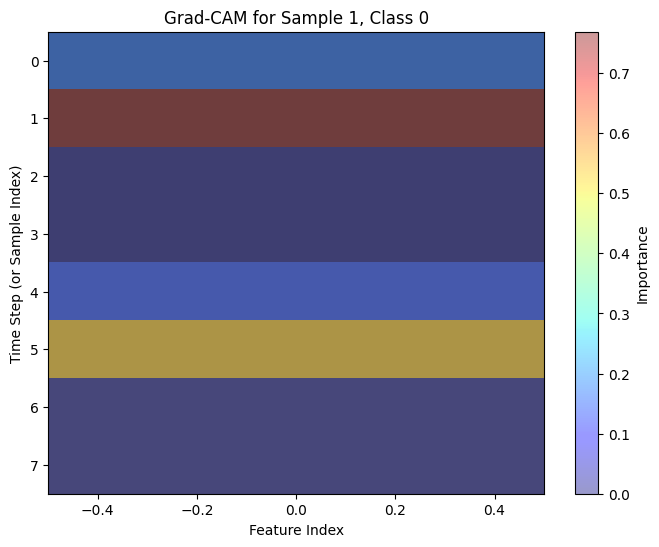

1/1 [==============================] - 0s 43ms/step


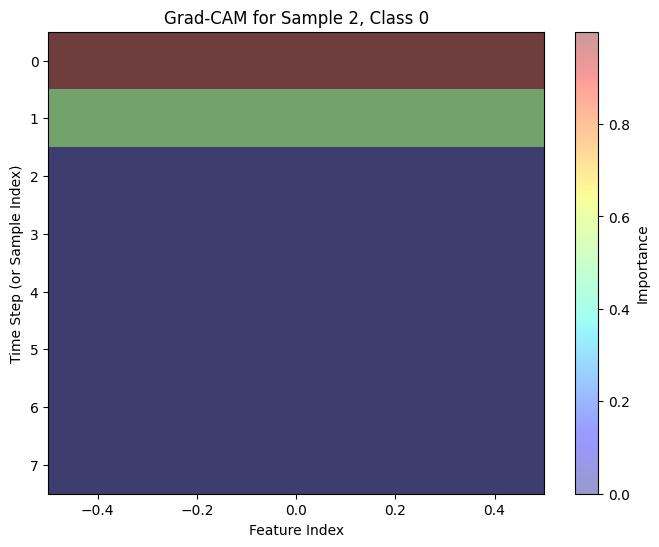

1/1 [==============================] - 0s 134ms/step


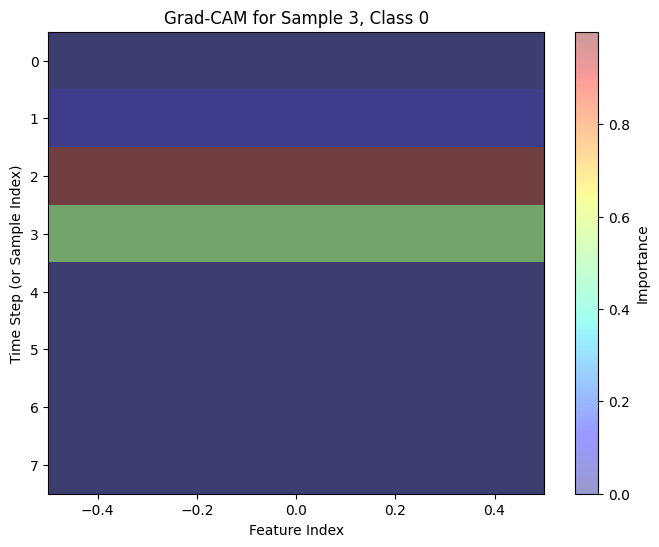

1/1 [==============================] - 0s 134ms/step


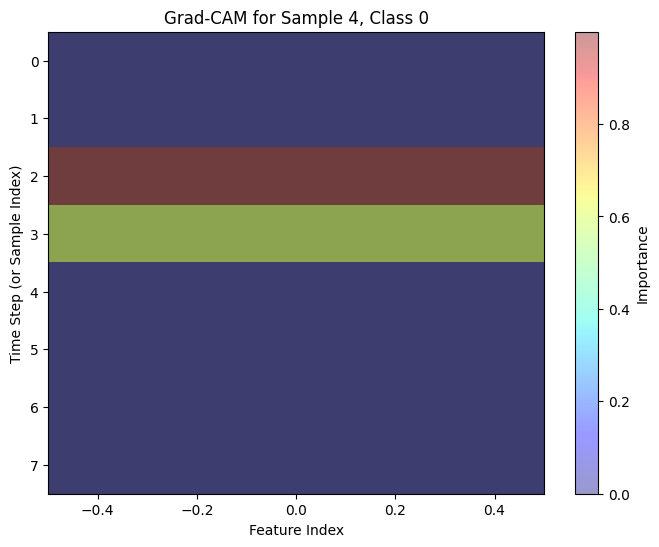

1/1 [==============================] - 0s 94ms/step


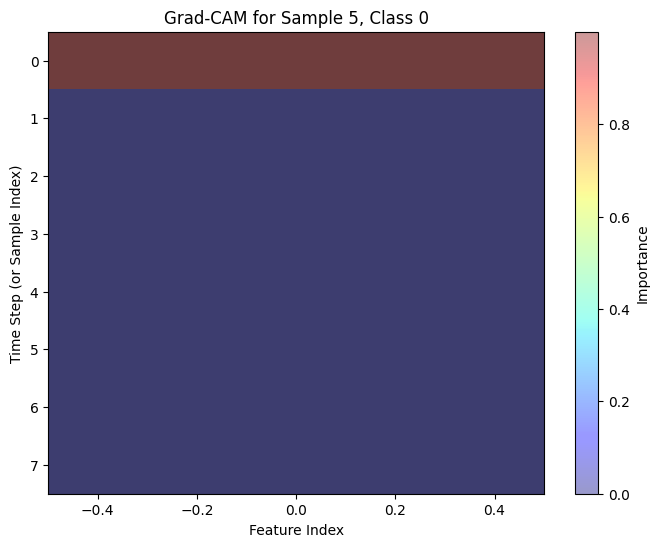

In [27]:
for i in range(5):
    sample_input = np.expand_dims(X_train[i + 5], axis=0)  # Select and reshape a single sample
    predicted_class = np.argmax(cnn_model.predict(sample_input))  # Get predicted class
    grad_cam_heatmap = compute_grad_cam(cnn_model, sample_input, class_index=predicted_class)

    # Visualize Grad-CAM for each sample
    visualize_grad_cam(grad_cam_heatmap, sample_input, title=f"Grad-CAM for Sample {i+1}, Class {predicted_class}")
